# Generate multi-omics data

Assume that you've complete the model training process. You can run the following command to generate new multiome latent representations:
```
cd script/training_diffusion
sh ssh_scripts/multimodal_sample.sh
```
Change the `MULTIMODAL_MODEL_PATH` in the sh file to the checkpoint path in step 2, and the `DATA_DIR` to your local data path. Also change other parameters to align with the training process. The `specific_type` is to specify the generation cell type. If not set, generate cell in proportion to the cell type in the original dataset by default. The `all_save_num` is the number of cells you want to generate.

After that, the generated cells latent representations will be saved in the `OUT_DIR`. You can follow the below script to decode them back to original space.

First thing first, import packages and set related paths:

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
import scanpy as sc
import anndata as ad
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import stats
from scdiffusionX.utils import MMD, LISI, random_forest, norm_total
import pandas as pd
from torch.distributions import Normal
from scvi.distributions import NegativeBinomial
from torch.distributions import Poisson, Bernoulli
import muon as mu
import yaml
import seaborn as sns  
from tqdm import tqdm

from scdiffusionX.Autoencoder.data.scrnaseq_loader import RNAseqLoader
from scdiffusionX.Autoencoder.models.base.encoder_model import EncoderModel

/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/lightning_lite/__init__.py:29: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_lite')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/pytorch_lightning/__init__.py:45: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/umap/__init__.py:9: ImportWarning

In [2]:
# set model and data path
encoder_config = "/stor/lep/workspace/scDiffusion-X/script/training_autoencoder/configs/encoder/encoder_multimodal_small.yaml"
dataset_path = '/stor/lep/diffusion/multiome/openproblem_filtered.h5mu'
covariate_keys = "cell_type" #"leiden"
num_class = 22
ae_path = "/stor/lep/workspace/scDiffusion-X/script/training_autoencoder/outputs/checkpoints/my_autoencoder1/checkpoints/last.ckpt"

Then, load the dataset:

In [3]:
mdata = mu.read_h5mu(dataset_path)
gene_names = mdata['rna'].var_names
real_cell = mdata['rna'][::10].X.toarray()
real_cell2 = mdata['atac'][::10].X.toarray()
cell_type = mdata['rna'][::10].obs['cell_type'].values
type_list = np.unique(mdata['rna'][::10].obs['cell_type'].values)
real_cell.shape

/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


(6925, 13431)

After that, decode the generated latent representations back to original space:

In [4]:
# get size factor for encoder
dataset = RNAseqLoader(data_path=dataset_path,
                            layer_key='X_counts',
                            covariate_keys=[covariate_keys],
                            subsample_frac=1, 
                            encoder_type='learnt_autoencoder',
                            multimodal=True,
                            is_binarized=True)

size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                            "sd": dataset.log_size_factor_sd}

def get_size_factor(type_index):
    covariate_indices = {}
    covariate_indices[covariate_keys] = type_index

    mean_size_factor, sd_size_factor = size_factor_statistics["mean"][covariate_keys], size_factor_statistics["sd"][covariate_keys]
    mean_size_factor, sd_size_factor = mean_size_factor[covariate_indices[covariate_keys]], sd_size_factor[covariate_indices[covariate_keys]]
    size_factor_dist = Normal(loc=mean_size_factor, scale=sd_size_factor)
    log_size_factor = size_factor_dist.sample().view(-1, 1)
    size_factor = torch.exp(log_size_factor)
    return {"rna": size_factor}

/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


In [5]:
# Load encoder and decoder
with open(encoder_config, 'r') as file:
    yaml_content = file.read()
autoencoder_args = yaml.safe_load(yaml_content)

# Initialize encoder
autoencoder_args['encoder_kwargs']['rna']['norm_type']='layernorm'
autoencoder_args['encoder_kwargs']['atac']['norm_type']='layernorm'
encoder_model = EncoderModel(in_dim={'atac': real_cell2.shape[1], 'rna': real_cell.shape[1]},
                                    n_cat=mdata['rna'].obs[covariate_keys].unique().shape[0],
                                    conditioning_covariate=covariate_keys, 
                                    encoder_type='learnt_autoencoder',
                                    **autoencoder_args)

# Load weights 
encoder_model.load_state_dict(torch.load(ae_path)["state_dict"])

/tmp/ipykernel_3823409/2298869578.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_model.load_state_dict(torch.load(ae_path)["state_dict"])


<All keys matched successfully>

In [14]:
import time
start_time = time.time()
batch = {}
size_factor = {'rna':torch.tensor(real_cell[:2000]).sum(1).view(-1, 1)}
batch["X_norm"] = {'rna':torch.tensor(real_cell[:2000]),'atac':torch.tensor(real_cell2[:2000])}
z = encoder_model.encode(batch)
mu_hat = encoder_model.decode(z, size_factor)
print(time.time()-start_time)

0.24787044525146484


Note: these data (`rna_seq`, `atac_seq`, and `type_index`) are saved in your `OUT_DIR`, change the path to your own.

In [12]:
# read generated latent representation and decode back to gene expression/atac seq
rna_seq = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/dpm_solver_80w_condi_big/RNA_0.npz')['data']
atac_seq = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/dpm_solver_80w_condi_big/ATAC_0.npz')['data']
type_index = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/dpm_solver_80w_condi_big/RNA_0.npz')['label']

# load norm factor for encoder
npzfile = np.load('/'.join(ae_path.split('/')[:-2])+'/norm_factor.npz')
rna_std = npzfile['rna_std']
atac_std = npzfile['atac_std']
z = {'rna':torch.tensor(rna_seq*rna_std).squeeze(1),'atac':torch.tensor(atac_seq*atac_std).squeeze(1)}

# get size factor and decode
size_factor = get_size_factor(torch.tensor(type_index,dtype=torch.int))
mu_hat = encoder_model.decode(z, size_factor)

sample = {}  # containing final samples 
for mod in mu_hat:
    if mod=="rna":  
        distr = NegativeBinomial(mu=mu_hat[mod], theta=torch.exp(encoder_model.theta))
    else:  # if mod is atac
        if not encoder_model.is_binarized:
            distr = Poisson(rate=mu_hat[mod])
        else:
            distr = Bernoulli(probs=mu_hat[mod])
    sample[mod] = distr.sample() 

reconstruct = sample['rna'][:real_cell.shape[0]].detach().numpy()
reconstruct2 = sample['atac'][:real_cell.shape[0]].detach().numpy()
type_index = type_index[:real_cell.shape[0]]

reconstruct.shape

(6925, 13431)

Here `reconstruct` is the generated scRNA-seq, `reconstruct2` is the gerated scATAC-seq data. You can evaluate your generation results with the following scripts:

In [7]:
print('RNA')
print(real_cell.mean())
print(reconstruct.mean())
print('spearman=',stats.spearmanr(real_cell.mean(axis=0), reconstruct.mean(axis=0)).correlation)
print('pearson=',np.corrcoef(real_cell.mean(axis=0), reconstruct.mean(axis=0))[0][1])
print('MSE=',np.mean((reconstruct-real_cell)**2))
print('L2 Norm=',np.linalg.norm(reconstruct.mean(axis=0)-real_cell.mean(axis=0)))

print('\nATAC')
print(real_cell2.mean())
print(reconstruct2.mean())
print('spearman=',stats.spearmanr(real_cell2.mean(axis=0), reconstruct2.mean(axis=0)).correlation)
print('pearson=',np.corrcoef(real_cell2.mean(axis=0), reconstruct2.mean(axis=0))[0][1])
print('MSE=',np.mean((reconstruct2-real_cell2)**2))
print('L2 Norm=',np.linalg.norm(reconstruct2.mean(axis=0)-real_cell2.mean(axis=0)))

RNA
0.14379396
0.14475352
spearman= 0.9913733776473627
pearson= 0.987588422541502
MSE= 7.6237383
L2 Norm= 13.169576

ATAC
0.07920893
0.07917095
spearman= 0.9850661563393119
pearson= 0.9977483111114237
MSE= 0.13435104
L2 Norm= 0.97393376


In [8]:
print('RNA')
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))
print('AUC = ', random_forest(adata))

print('\nATAC')
adata = np.concatenate((real_cell2, reconstruct2),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))
print('AUC = ', random_forest(adata))

RNA


100%|██████████| 70/70 [00:16<00:00,  4.31it/s]


MMD =  tensor(0.0025)
LISI =  0.8510099970259501
AUC =  0.6675026483686849

ATAC


100%|██████████| 70/70 [00:15<00:00,  4.44it/s]


MMD =  tensor(0.0008)
LISI =  0.9244179941358288
AUC =  0.5611923262683485


You can also draw the UMAP to see if the generated data align well with the original data:

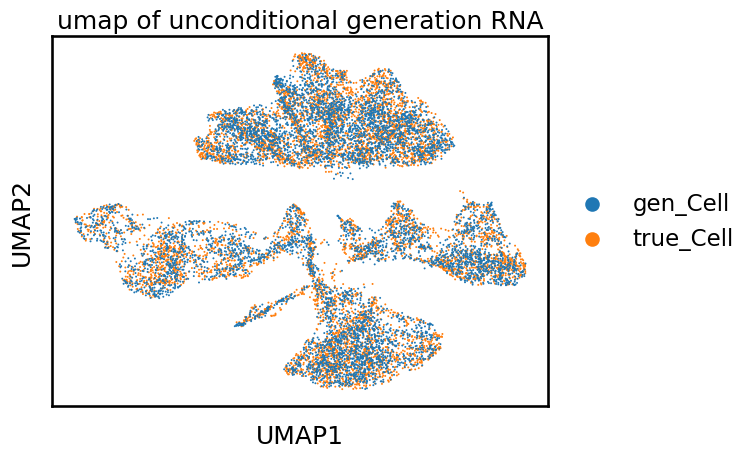

In [ ]:
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)

adata.obs['cell_name'] = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
adata.obs['cell_type'] = list(cell_type) + ['gen '+type_list[type] for type in type_index]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.pl.umap(adata, color='cell_name', size=8, title='umap of unconditional generation RNA')
# plt.legend(loc = 'upper right')

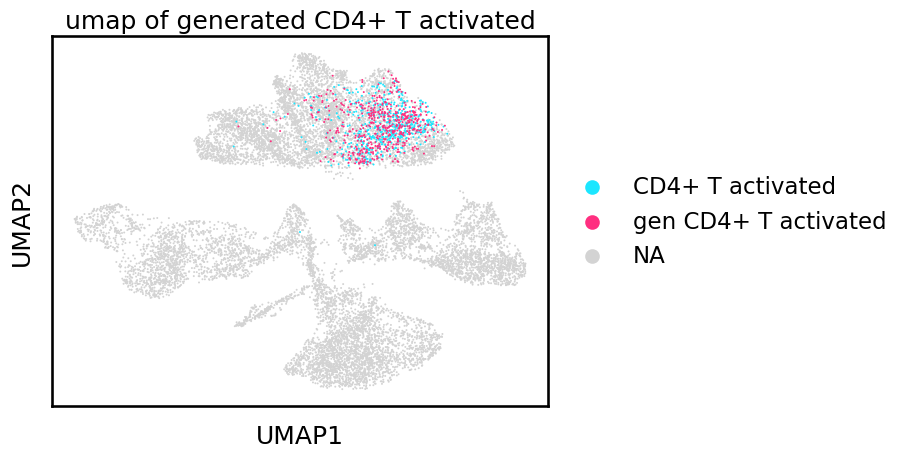

In [24]:
sc.pl.umap(adata, color='cell_type',groups=['CD4+ T activated','gen CD4+ T activated'], size=8, title='umap of generated CD4+ T activated')
# plt.legend(loc = 'upper right')

/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


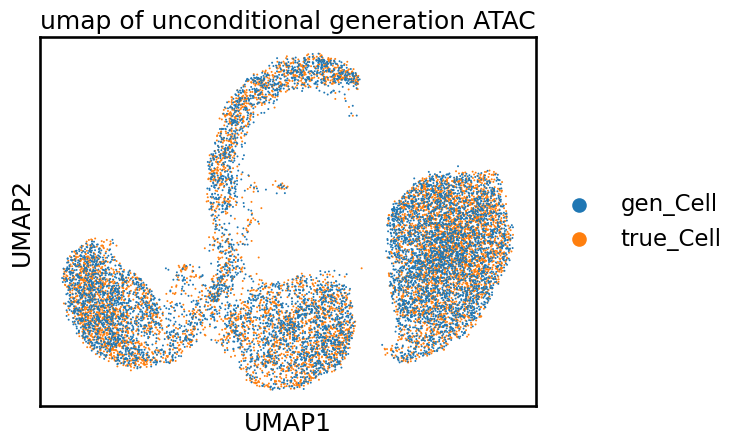

In [16]:
adata = np.concatenate((real_cell2, reconstruct2),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
# adata.var_names = gene_names
adata.obs['cell_name'] = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]

sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# adata.raw = adata
# adata = adata[:, adata.var.highly_variable]

# sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.pl.umap(adata, color='cell_name', size=8, title='umap of unconditional generation ATAC')
# plt.legend(loc = 'upper right')

For each cell type, you can evaluate them one by one. Here is an example on the Openproblem dataset:

In [ ]:
from tqdm import tqdm
type_list = ['B1 B', 'CD14+ Mono', 'CD16+ Mono', 'CD4+ T activated',
        'CD4+ T naive', 'CD8+ T', 'CD8+ T naive', 'Erythroblast',
        'G/M prog', 'HSC', 'ID2-hi myeloid prog', 'ILC', 'Lymph prog',
        'MK/E prog', 'NK', 'Naive CD20+ B', 'Normoblast', 'Plasma cell',
        'Proerythroblast', 'Transitional B', 'cDC2', 'pDC']
columns = ['cell type', 'RNA PCC', 'RNA SCC', 'RNA MMD', 'RNA LISI', 'RNA AUC', 'ATAC PCC', 'ATAC SCC', 'ATAC MMD', 'ATAC LISI', 'ATAC AUC']
type_index = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/dpm_solver_80w_condi_big/RNA_0.npz')['label'] # here we use all sampled data
df = pd.DataFrame(columns=columns)
for id, type in enumerate(type_list):
    # load different cell type and control the number of each type (to save evaluation time)
    total = (mdata['rna'].obs['cell_type']==type).sum()
    sample_index = np.random.choice(total, size=800, replace=False) if total>=800 else list(range(total))
    real_cell = mdata['rna'][mdata['rna'].obs['cell_type']==type].X.toarray()[sample_index]
    real_cell2 = mdata['atac'][mdata['atac'].obs['cell_type']==type].X.toarray()[sample_index]
    cell_num = min((type_index==id).sum(),real_cell.shape[0])
    reconstruct = sample['rna'][type_index==id][:cell_num].detach().numpy()
    reconstruct2 = sample['atac'][type_index==id][:cell_num].detach().numpy()
    real_cell = real_cell[:cell_num]
    real_cell2 = real_cell2[:cell_num]

    # calculate evaluation metric
    rna_scc = stats.spearmanr(real_cell.mean(axis=0), reconstruct.mean(axis=0)).correlation
    rna_pcc = np.corrcoef(real_cell.mean(axis=0), reconstruct.mean(axis=0))[0][1]
    atac_scc = stats.spearmanr(real_cell2.mean(axis=0), reconstruct2.mean(axis=0)).correlation
    atac_pcc = np.corrcoef(real_cell2.mean(axis=0), reconstruct2.mean(axis=0))[0][1]

    adata = np.concatenate((real_cell, reconstruct),axis=0)
    adata = ad.AnnData(adata, dtype=np.float32)
    adata.obs_names = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
    sc.tl.pca(adata, svd_solver='arpack')
    adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])])
    rna_mmd = MMD(adata)
    rna_lisi = LISI(adata)
    rna_auc = random_forest(adata)

    adata = np.concatenate((real_cell2, reconstruct2),axis=0)
    adata = ad.AnnData(adata, dtype=np.float32)
    adata.obs_names = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]
    sc.tl.pca(adata, svd_solver='arpack')
    adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])])
    atac_mmd = MMD(adata)
    atac_lisi = LISI(adata)
    atac_auc = random_forest(adata)

    df.loc[id] = [type, rna_pcc, rna_scc, rna_mmd, rna_lisi, rna_auc, atac_pcc, atac_scc, atac_mmd, atac_lisi, atac_auc]

100%|██████████| 9/9 [00:00<00:00, 88.48it/s]


In [ ]:
df.to_csv('eval_results/diffusion.csv', index=False) # save it if you want
df

,cell type,RNA PCC,RNA SCC,RNA MMD,RNA LISI,RNA AUC,ATAC PCC,ATAC SCC,ATAC MMD,ATAC LISI,ATAC AUC
0,B1 B,0.987566,0.967615,tensor(0.0150),0.833364,0.797694,0.986721,0.979733,tensor(0.0106),0.899214,0.595788
1,CD14+ Mono,0.992969,0.975501,tensor(0.0269),0.873068,0.677646,0.981683,0.975874,tensor(0.0077),0.905203,0.597564
2,CD16+ Mono,0.995610,0.982333,tensor(0.0422),0.806425,0.786214,0.982685,0.974554,tensor(0.0622),0.847424,0.660114
3,CD4+ T activated,0.997701,0.972190,tensor(0.0183),0.879269,0.670718,0.988320,0.978231,tensor(0.0072),0.888342,0.633578
4,CD4+ T naive,0.997946,0.974163,tensor(0.0353),0.839855,0.745648,0.989293,0.979403,tensor(0.0133),0.877567,0.604692
5,CD8+ T,0.996127,0.969788,tensor(0.0249),0.784428,0.730742,0.987550,0.979525,tensor(0.0238),0.911457,0.639081
6,CD8+ T naive,0.995426,0.973165,tensor(0.0270),0.806572,0.658188,0.990184,0.981577,tensor(0.0188),0.891647,0.647134
7,Erythroblast,0.998432,0.977005,tensor(0.0042),0.922589,0.734019,0.989771,0.966028,tensor(0.0187),0.886622,0.719638
8,G/M prog,0.981477,0.979162,tensor(0.0316),0.823997,0.794243,0.981967,0.969076,tensor(0.0131),0.892188,0.690201
9,HSC,0.987696,0.978155,tensor(0.0364),0.797329,0.767057,0.983788,0.974396,tensor(0.0166),0.853439,0.715586
